In [1]:
import networkx as nx
import copy

In [2]:
G = nx.Graph()
G.add_nodes_from(range(1, 7))
G.add_edges_from([
    (1,2),
    (1,3),
    (2,3),
    (2,4),
    (3,5),
    (4,6),
    (5,6)
])

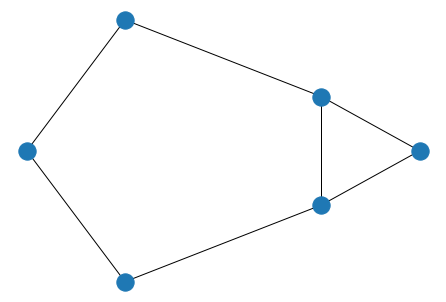

In [3]:
nx.draw_spectral(G)

In [4]:
list(G.edges)[0]

(1, 2)

In [164]:
class Node:
    '''
    We want our node to have:
        - An edge label, e_i = (v, w)
        - A cc number
        - A comp set
        - A fps set
        - (more? maybe F_i?)
    '''
    def __init__(self, edge, cc=0, comp=set(), fps=set()):
        self.edge = edge
        self.cc = cc # are we sure we want to initialize to 0?
        self.comp = comp
        self.fps = fps
    
    def summary(self):
        print(f" -- Node {self.edge}")
        print(f" --   cc {self.cc}")
        print(f" -- comp {self.comp}")
        print(f" --  fps {self.fps}")
        return

In [165]:
def makeNewNode(edges, K, n, i, x):
    v, w = n.edge
    m = len(edges)
    n_prime = copy.deepcopy(n)
    
    if (v, w) == (-1, -1):
        print("We're done!")
        return 0

    # construct the frontiers
    def constructFrontiers(edges, i):
        m = len(edges)
        if i == 0:
            prevFrontier = set()
        else:
            processed_edges = [set(edges[j]) for j in range(i)]
            unprocessed_edges = [set(edges[j]) for j in range(i, m)]
            prevFrontier = set().union(*processed_edges) & set().union(*unprocessed_edges)
        
        if i == m:
            currFrontier = set()
        else:
            processed_edges = [set(edges[j]) for j in range(i+1)]
            unprocessed_edges = [set(edges[j]) for j in range(i+1, m)]
            currFrontier = set().union(*processed_edges) & set().union(*unprocessed_edges)
        return prevFrontier, currFrontier
    
    prevFrontier, currFrontier = constructFrontiers(edges, i)
    
#     print(f"prevFrontier = {prevFrontier}\ncurrFrontier={currFrontier}")
            

    # if either of the vertices are entering the frontier, add them to comp
    for u in (v, w):
        if u not in prevFrontier:
            n_prime.comp.add(frozenset([u]))
            
    C_v, C_w = frozenset(), frozenset()
    for vertex_set in n_prime.comp:
        if v in vertex_set:
            C_v = copy.copy(vertex_set) # not sure if copy is needed
        if w in vertex_set:
            C_w = copy.copy(vertex_set)
            
    if C_v == frozenset() or C_w == frozenset():
        print("ERROR: C_v and C_w should be nonempty")

#     print(f"C_v = {C_v}, C_w = {C_w}")
    # if we are adding this edge, the components should now be connected
    if x == 1:
        n_prime.comp.discard(C_v) # discard removes x from set if x exists, otherwise nothing
        n_prime.comp.discard(C_w)
        n_prime.comp.add(C_v.union(C_w))
        # if they are a forbidden pair, return 0
        if C_v != C_w and frozenset((C_v, C_w)) in n_prime.fps:
            return 0
        # otherwise, replace all instances of C_v/C_w with their union in the fps
        else:
            fps_list = list(n_prime.fps)
            for elem in fps_list:
                new_elem = set(elem)
                if C_v in new_elem or C_w in new_elem:
                    if C_v in new_elem:
                        new_elem.remove(C_v)
                        new_elem.add(C_v.union(C_w))
                    if C_w in elem:
                        new_elem.remove(C_w)
                        new_elem.add(C_v.union(C_w))
                    new_elem = tuple(new_elem)
                    n_prime.fps.remove(elem)
                    n_prime.fps.add(new_elem)
                    
    else:
        # if we aren't adding this edge and the components are connected,
        # this violates induced subgraph, so return 0
        if C_v == C_w:
            return 0
        # if they aren't connected, add their connected components to the fps
        else:
            n_prime.fps.add(tuple((C_v, C_w)))
            
    
    # if either of the vertices are leaving the frontier...
    for u in (v, w):
        if u not in currFrontier:
            # if u is an isolated component, increment our cc by 1
            if frozenset([u]) in n_prime.comp:
                n_prime.cc += 1
                # remove it from the range of the comp or fps's views...
                n_prime.comp.remove(frozenset([u]))
                # if we have too many cc's, return 0
                if n_prime.cc > max(K):
                    return 0
            
            # if u is a part of a connected component, take it out
            comp_list = list(n_prime.comp)
            for elem in comp_list:
                if u in elem:
                    new_elem = set(elem)
                    new_elem.remove(u)
                    new_elem = frozenset(new_elem)
                    n_prime.comp.remove(elem)
                    n_prime.comp.add(new_elem)
            
            # if {{u}, X} is in n_prime.fps for any X in n_prime.comp, take it out
            fps_list = list(n_prime.fps)
            for elem in fps_list:
                if frozenset([u]) in elem:
                    n_prime.fps.remove(elem)

    # if we are on the last edge, check to see if we have partitioned
    # the graph into the right number of cells
    if i == m:
        if n_prime.cc in K:
            return 1
        else:
            return 0
        
    return n_prime

In [166]:
def constructZDD(G):
    m = len(G.edges)
    edges = list(G.edges) + [(-1,-1)]
    Nodes = [copy.deepcopy([]) for _ in range(m+1)] # should eventually be a list of sets?
    Nodes[0].append(Node(edges[0]))
    for i in range(0, m):
        for n in Nodes[i]:
            for x in [0, 1]:
                print(f"Trying to create a {x}-arc")
                n.summary()
                choice = "Choosing" if x else "NOT choosing"
                
                n_prime = makeNewNode(edges, [2], n, i, x)
                
                if n_prime == 0 or n_prime == 1:
                    print(f"{choice} {n.edge} leads to {n_prime}\n")
#                 else:
#                     print(f"{choice} {n.edge}")
                
                if n_prime != 0 and n_prime != 1:
                    for n_pp in Nodes[i+1]:
#                         print(f"n_prime.comp = {n_prime.comp}")
#                         print(f"n_pp.comp = {n_pp.comp}")
#                         print(f"n_prime.edge = {n_prime.edge}")
#                         print(f"n_pp.edge = {n_pp.edge}")
                        if n_prime.comp == n_pp.comp:
                            print("FOUND A COPY")
                            n_prime = copy.copy(n_pp) # right?
                    n_prime = Node(edges[i+1], n_prime.cc, n_prime.comp, n_prime.fps)
                    print("WE ARE APPENDING THE FOLLOWING NODE:")
                    n_prime.summary()
                    print("")
                    Nodes[i+1].append(n_prime)
    return Nodes

In [167]:
for n in Nodes[0]:
    n.summary()

 -- Node (1, 2)
 --   cc 0
 -- comp set()
 --  fps set()


In [168]:
for n in Nodes[1]:
    n.summary()
    print()

 -- Node (1, 3)
 --   cc 0
 -- comp {frozenset({2}), frozenset({1})}
 --  fps {(frozenset({1}), frozenset({2}))}

 -- Node (1, 3)
 --   cc 0
 -- comp {frozenset({1, 2})}
 --  fps set()



In [169]:
for n in Nodes[2]:
    n.summary()
    print()

 -- Node (2, 3)
 --   cc 1
 -- comp {frozenset({3}), frozenset({2})}
 --  fps set()

 -- Node (2, 3)
 --   cc 1
 -- comp {frozenset({3}), frozenset({2})}
 --  fps set()

 -- Node (2, 3)
 --   cc 1
 -- comp {frozenset({3}), frozenset({2})}
 --  fps set()

 -- Node (2, 3)
 --   cc 0
 -- comp {frozenset({2, 3})}
 --  fps set()



In [170]:
Nodes = constructZDD(G)

Trying to create a 0-arc
 -- Node (1, 2)
 --   cc 0
 -- comp set()
 --  fps set()
WE ARE APPENDING THE FOLLOWING NODE:
 -- Node (1, 3)
 --   cc 0
 -- comp {frozenset({2}), frozenset({1})}
 --  fps {(frozenset({1}), frozenset({2}))}

Trying to create a 1-arc
 -- Node (1, 2)
 --   cc 0
 -- comp set()
 --  fps set()
WE ARE APPENDING THE FOLLOWING NODE:
 -- Node (1, 3)
 --   cc 0
 -- comp {frozenset({1, 2})}
 --  fps set()

Trying to create a 0-arc
 -- Node (1, 3)
 --   cc 0
 -- comp {frozenset({2}), frozenset({1})}
 --  fps {(frozenset({1}), frozenset({2}))}
WE ARE APPENDING THE FOLLOWING NODE:
 -- Node (2, 3)
 --   cc 1
 -- comp {frozenset({3}), frozenset({2})}
 --  fps set()

Trying to create a 1-arc
 -- Node (1, 3)
 --   cc 0
 -- comp {frozenset({2}), frozenset({1})}
 --  fps {(frozenset({1}), frozenset({2}))}
FOUND A COPY
WE ARE APPENDING THE FOLLOWING NODE:
 -- Node (2, 3)
 --   cc 1
 -- comp {frozenset({3}), frozenset({2})}
 --  fps set()

Trying to create a 0-arc
 -- Node (1, 3)
 -